# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '../../')

In [3]:
from src.serve import *

Failed to load FluidSynth. Must install if you want to convert to wav files.


In [4]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [5]:
data_dir = 'data/midi/v10/'
source_dir = 'midi_encode'

file_path = Path('../../')
path = file_path/data_dir/source_dir
out_path = file_path/'data/generated/'

In [6]:
# config = v10_small_config(vocab_path=path/'tmp/all'); config
config = v10_single_config(vocab_path=path/'tmp/all'); config
config['mem_len'] = 1024
config['bptt'] = 512

In [7]:
data = load_data(path=path, cache_name='tmp/hook', **config)

In [8]:
saved_models = get_files(path/'models/single', recurse=True); saved_models

[PosixPath('../../data/midi/v10/midi_encode/models/single/small/hook_c/1_ep24.pth'),
 PosixPath('../../data/midi/v10/midi_encode/models/single/hook_c/1_ep48_best.pth')]

In [9]:
load_path = saved_models[-1]

In [10]:
learn = load_learner(data, config, load_path)

Sep_idx: 1


In [11]:
# htlist = get_htlist(path, source_dir)

### From batch

In [12]:
xb,yb = learn.data.one_batch(cpu=False)

### From song

In [13]:

csv_path = path/f'{source_dir}.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

/Users/andrewshaw/miniconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('canon')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory']; results.head()

,ht_bpm,md5,numpy,ht_time_signature,midi_title,source,artist,ht_offset,section,song_url,mxl,ht_key,parts,title,genres,midi,ht_mode
970,128.0,c1e4271a0f4a68ed4a3a9cf58a36ff4f,midi_encode/hooktheory/pianoroll/j/johann-seba...,4.0,Canon 1 a 2,hooktheory,johann-sebastian-bach,-3.0,instrumental,https://www.hooktheory.com/theorytab/view/joha...,NaN,C,instrumental,canon-1-a-2,Classical,midi_sources/hooktheory/pianoroll/j/johann-seb...,6.0
1491,132.0,3c6944b6a2dd648b6c7c8a5f2b0b3c5f,midi_encode/hooktheory/pianoroll/j/johann-pach...,4.0,Canon Prechorus,hooktheory,johann-pachelbel,-2.0,pre-chorus,https://www.hooktheory.com/theorytab/view/joha...,NaN,D,"intro,pre-chorus,chorus",canon-in-d-major,NaN,midi_sources/hooktheory/pianoroll/j/johann-pac...,1.0
1492,138.0,ba9c087d394b5f5f00402fbb8a265834,midi_encode/hooktheory/pianoroll/j/johann-pach...,4.0,Pachelbel Canon Chorus,hooktheory,johann-pachelbel,-2.0,chorus,https://www.hooktheory.com/theorytab/view/joha...,NaN,D,"intro,pre-chorus,chorus",canon-in-d-major,NaN,midi_sources/hooktheory/pianoroll/j/johann-pac...,1.0
1493,130.0,9fe819012e091691cb0636484dc9609b,midi_encode/hooktheory/pianoroll/j/johann-pach...,4.0,Pachelbel Canon in D,hooktheory,johann-pachelbel,-2.0,intro,https://www.hooktheory.com/theorytab/view/joha...,NaN,D,"intro,pre-chorus,chorus",canon-in-d-major,NaN,midi_sources/hooktheory/pianoroll/j/johann-pac...,1.0


In [15]:
file = file_path/data_dir/results.numpy.values[0]; file

PosixPath('../../data/midi/v10/midi_encode/hooktheory/pianoroll/j/johann-sebastian-bach/canon-1-a-2/instrumental_key_original.npy')

In [16]:
# file = np.random.choice(files)

In [17]:
#good_one = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/c/cool-and-new-web-comic/tick---tock/chorus.npy')
# file = Path('../../data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy')
# third_eye = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy')

In [22]:
orig = Path('../../data/midi/v10/midi_sources/hooktheory/pianoroll/j/johann-sebastian-bach/canon-1-a-2/instrumental_key_original.mid')

In [18]:
seed_len = 140
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np))[None]
if torch.cuda.is_available(): xb = xb.cuda()

In [19]:
seed_np - 3

array([[-1, -3],
       [-2,  0],
       [60,  2],
       [55,  4],
       [51,  4],
       [48,  4],
       [-2,  1],
       [63,  2],
       [-2,  1],
       [67,  2],
       ...,
       [50,  2],
       [44,  2],
       [-2,  0],
       [68,  1],
       [-2,  0],
       [67,  1],
       [60,  4],
       [55,  4],
       [51,  4],
       [-2,  0]])

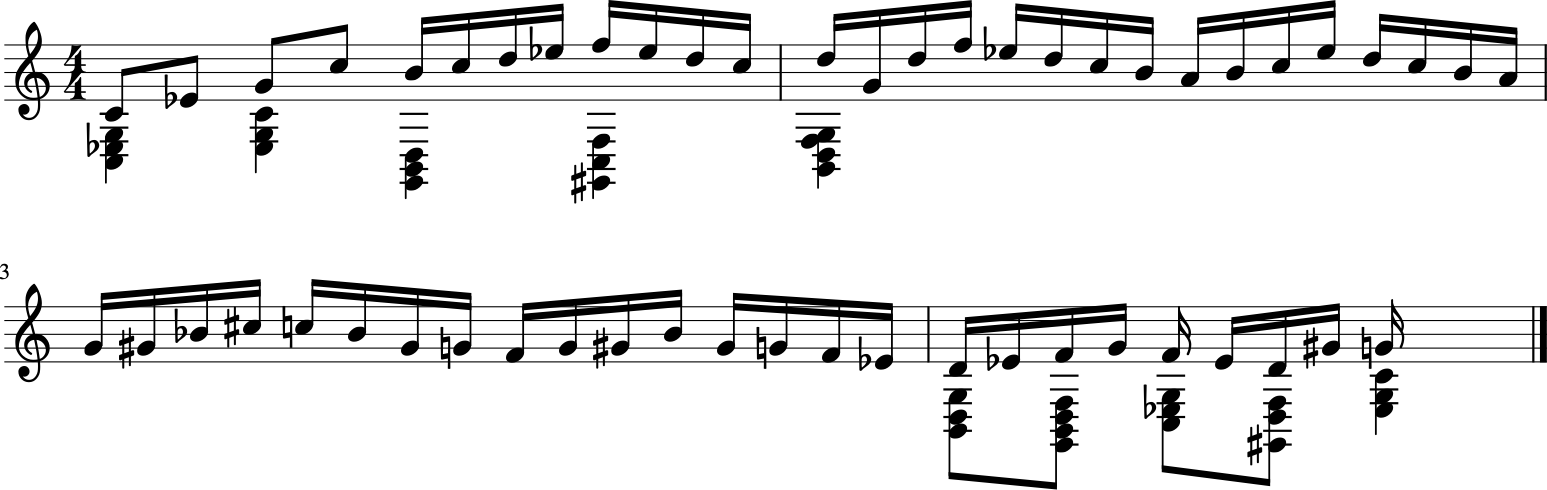

In [20]:
seed_stream = npenc2stream(seed_np)
seed_stream.show()

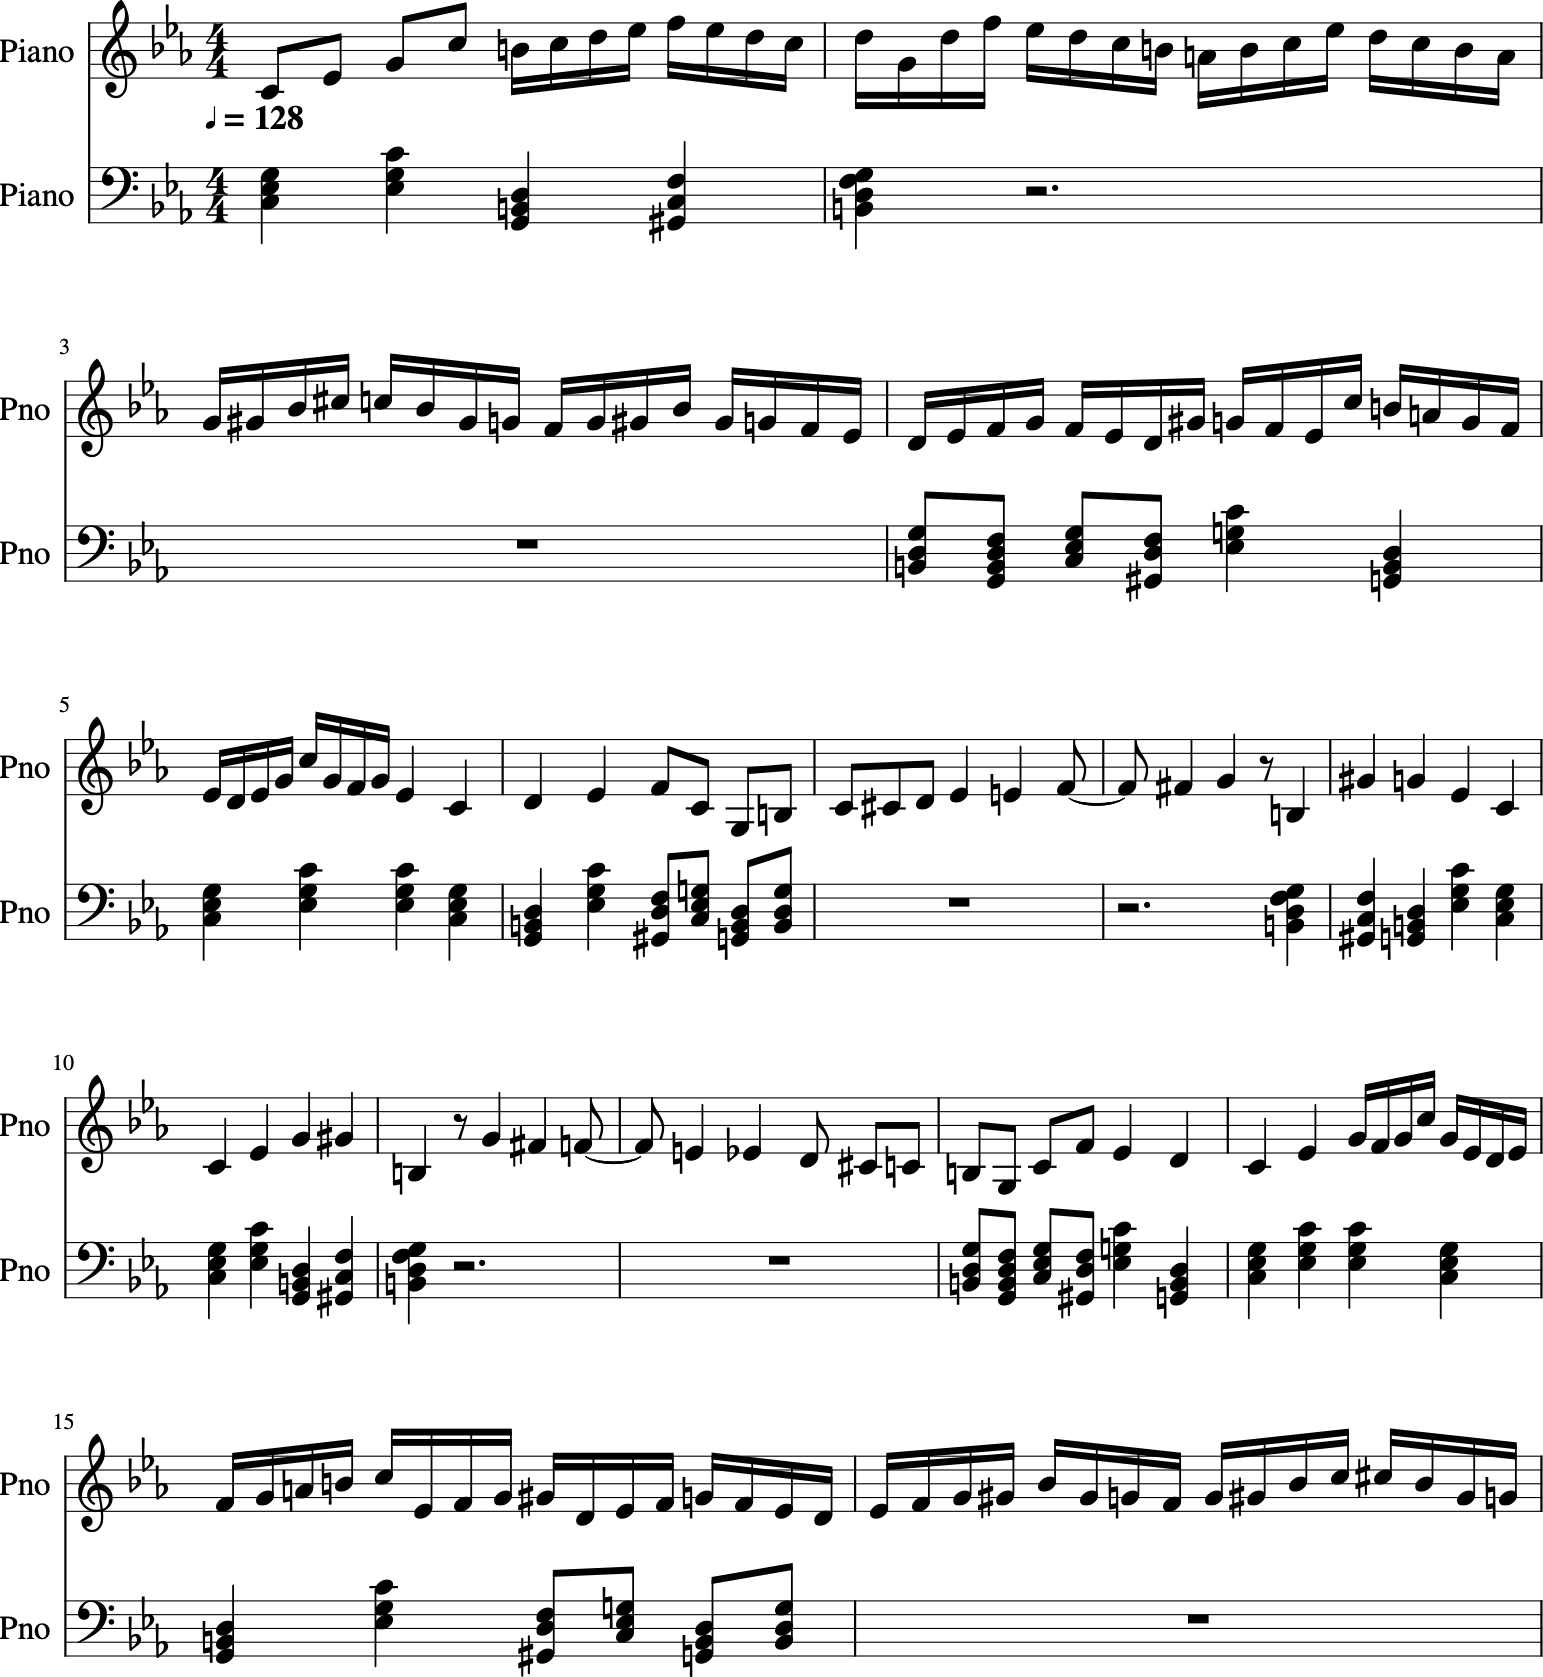

In [24]:
file2stream(orig).show()

### Predict

In [24]:
# res1 = torch.randint(0, 1000, (10,10)).float(); res1

# res2 = res1.pow(1 / 10)
# res2 = res2 / res2.sum()
# (res2*1000).round()/1000

# resd5 = res1.pow(1 / .5)
# resd5_prob = resd5 / resd5.sum()
# (resd5_prob*1000).round()/1000

In [25]:
# out, seed = learn.predict(xb, n_words=340, temperature=1, min_p=0.01)

In [26]:
# Higher temperature = More randomness (1.5)
# Lower temperature = Less random (.5)

## Learn predict

In [27]:
out_s, seed_s = learn.predict(xb, n_words=800, temperatures=(1.0,.5), min_ps=(1/128,0.0))
out = to_double_stream(out_s)
seed = to_double_stream(seed_s)

### Actual prediction

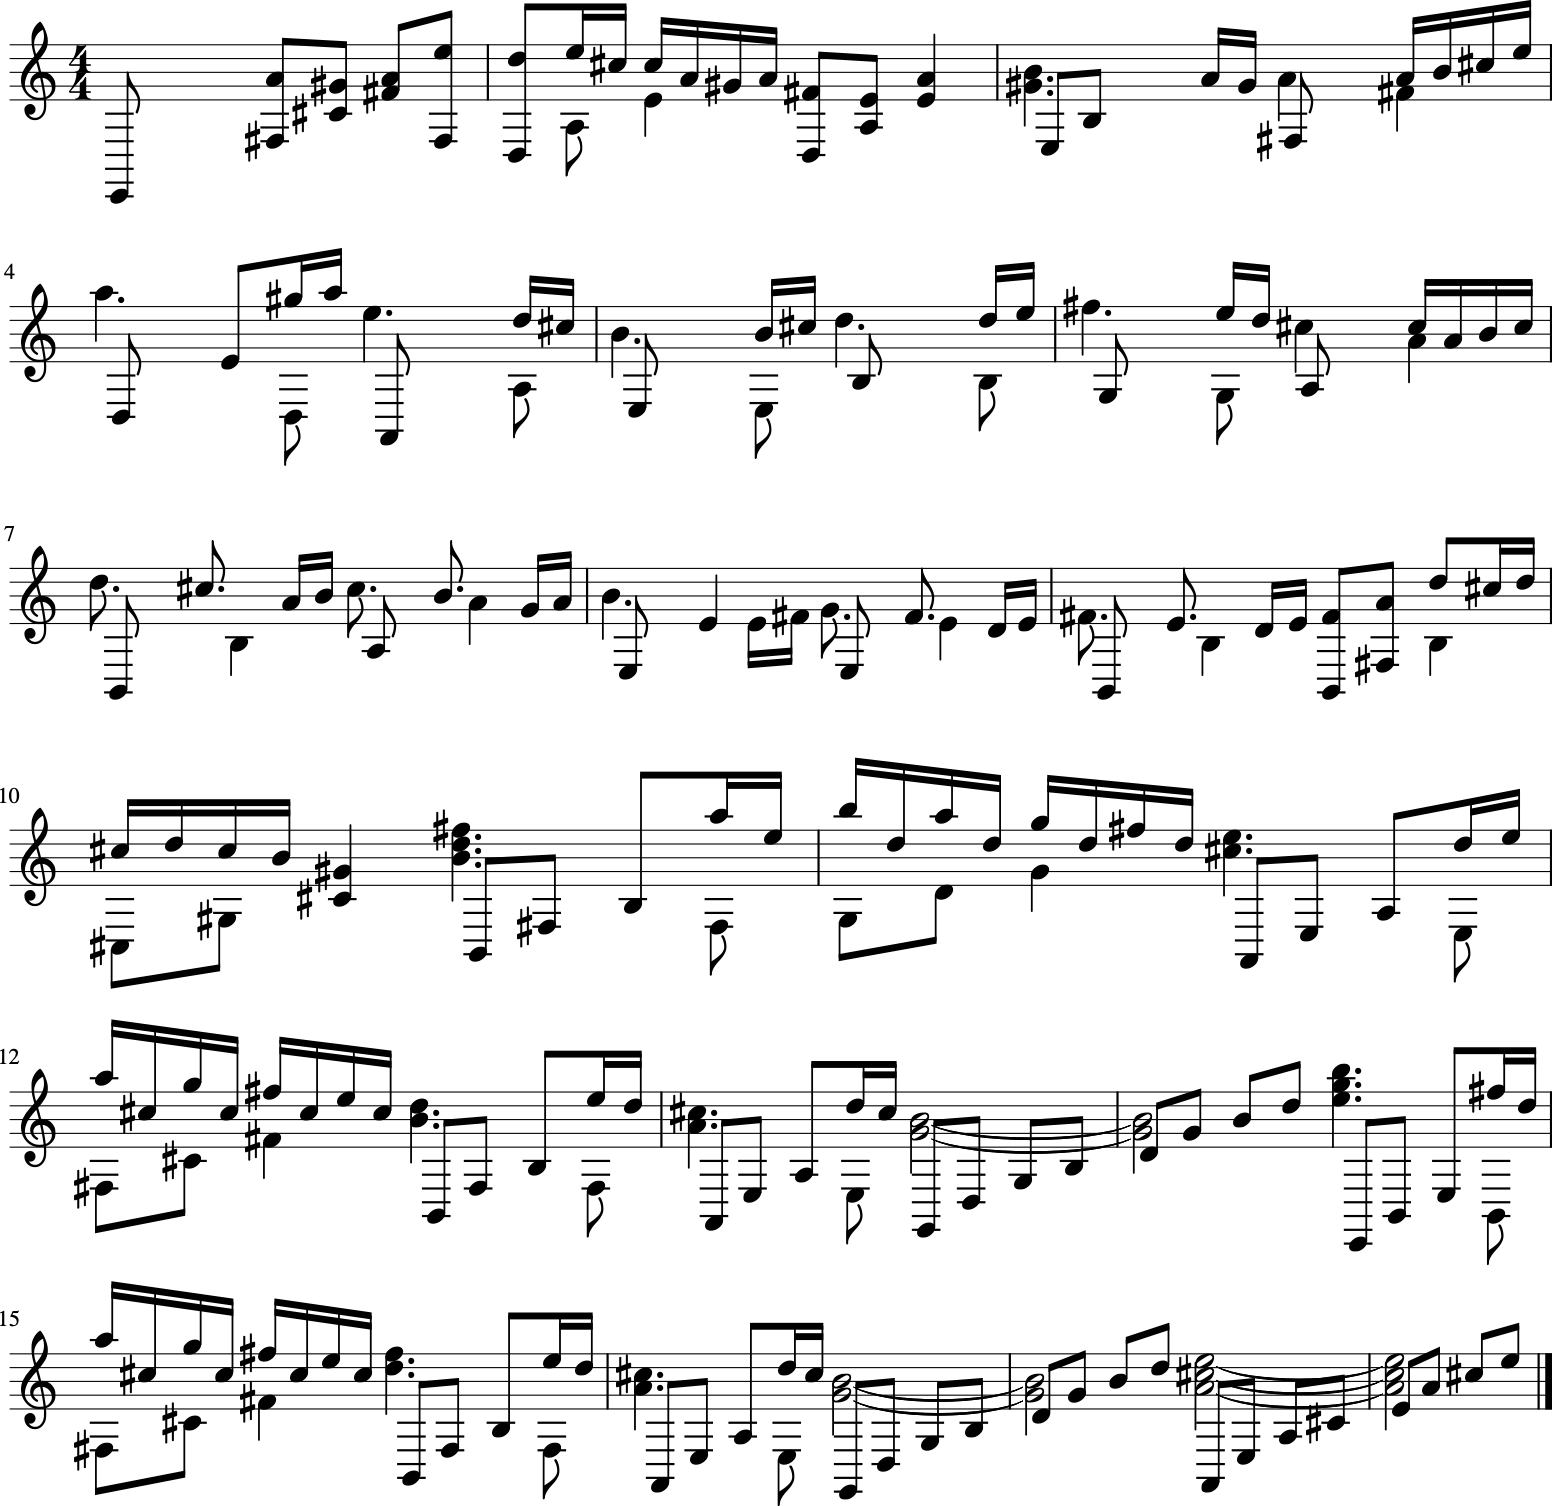

In [28]:
stream = npenc2stream(out)
stream.show()

In [29]:
stream.show('midi')

## Seed

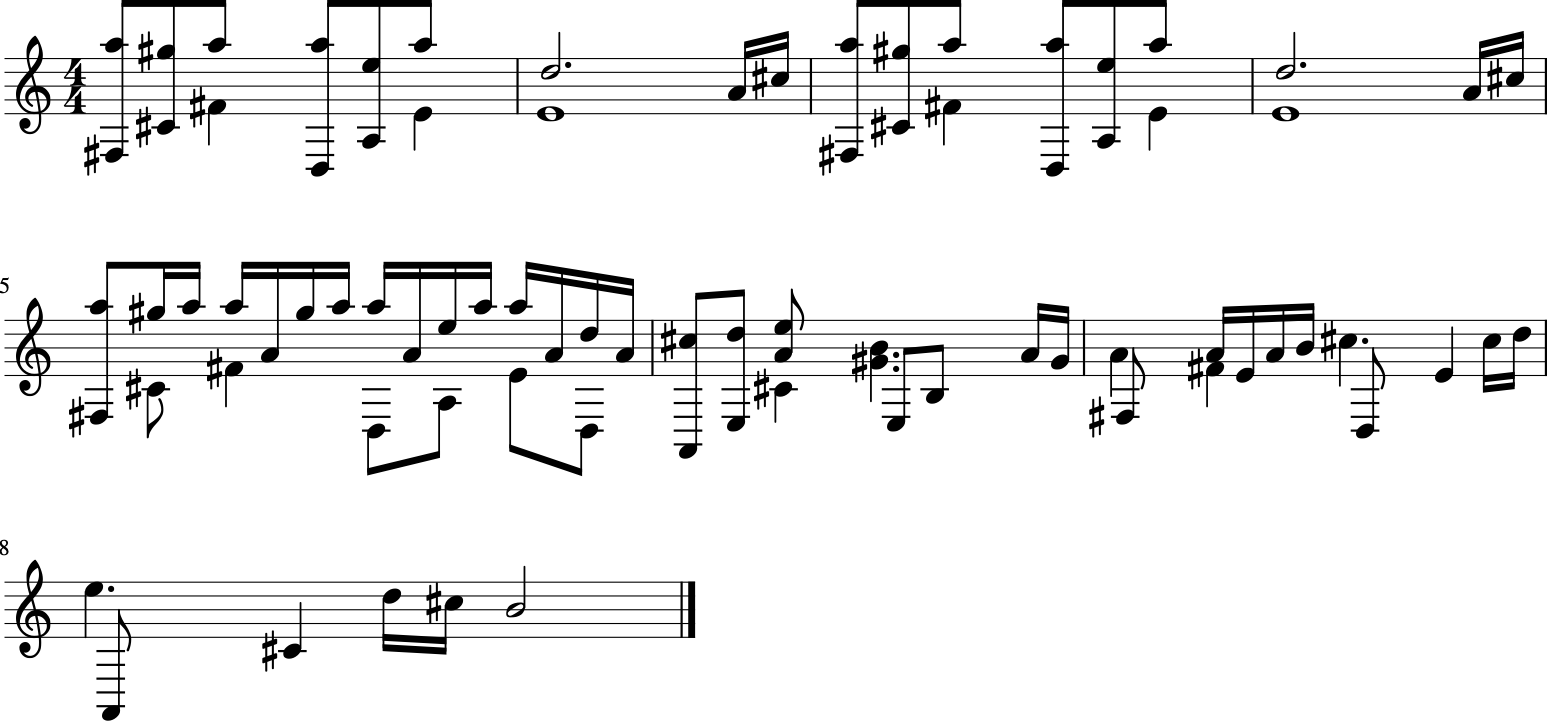

In [30]:
seed_stream = npenc2stream(seed)
seed_stream.show()

In [31]:
seed_stream.show('midi')

## Alltogether now

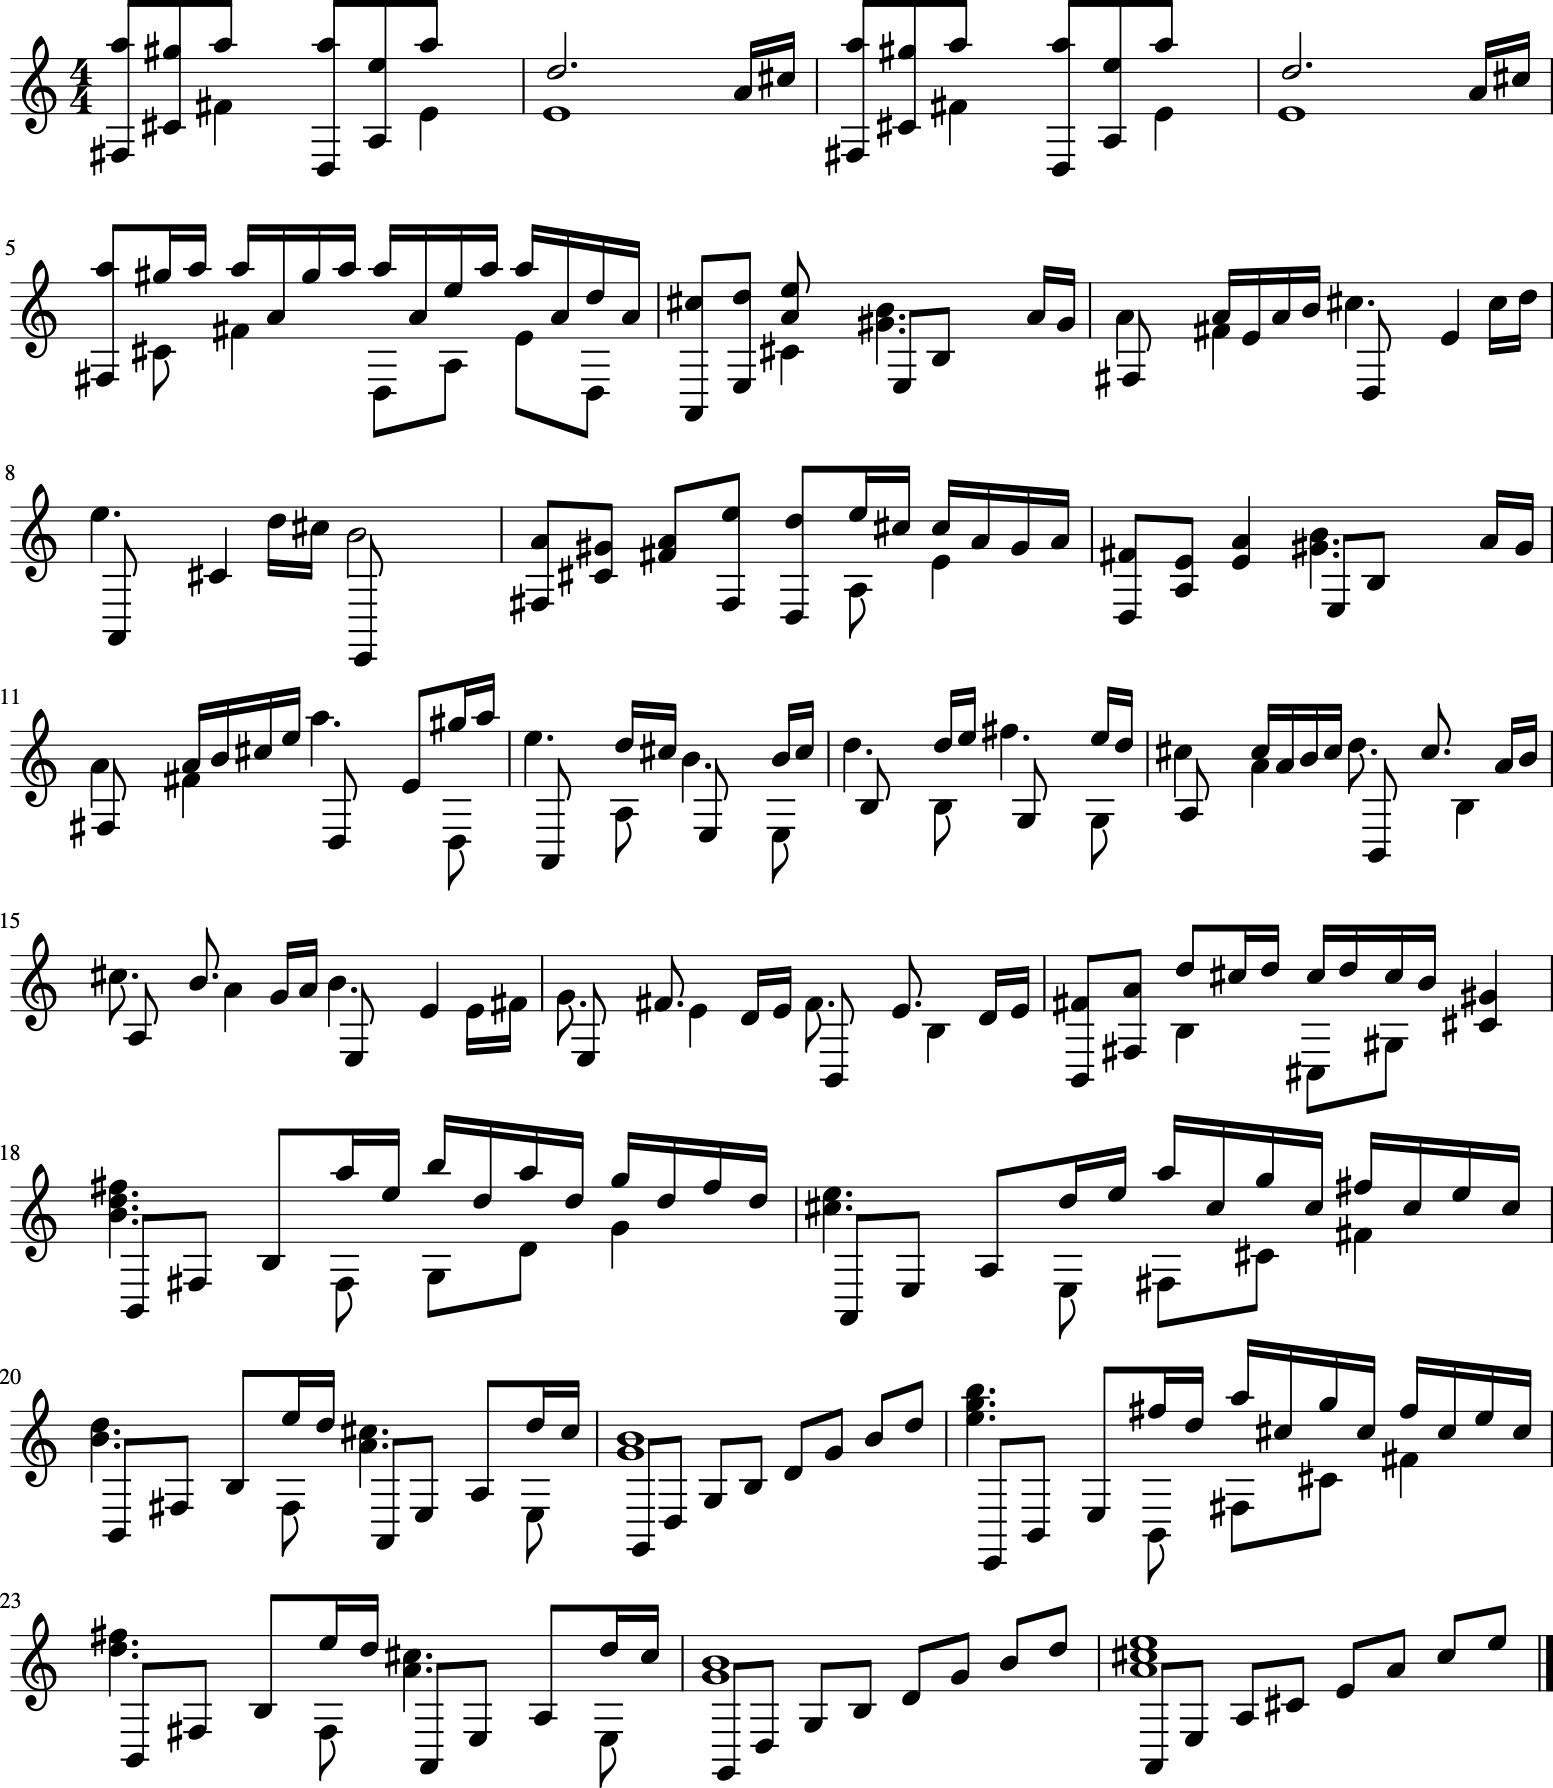

In [32]:
full_output = np.concatenate((seed,out), axis=0)
full_stream = npenc2stream(full_output)
full_stream.show()

In [33]:
full_stream.show('midi')

### Original

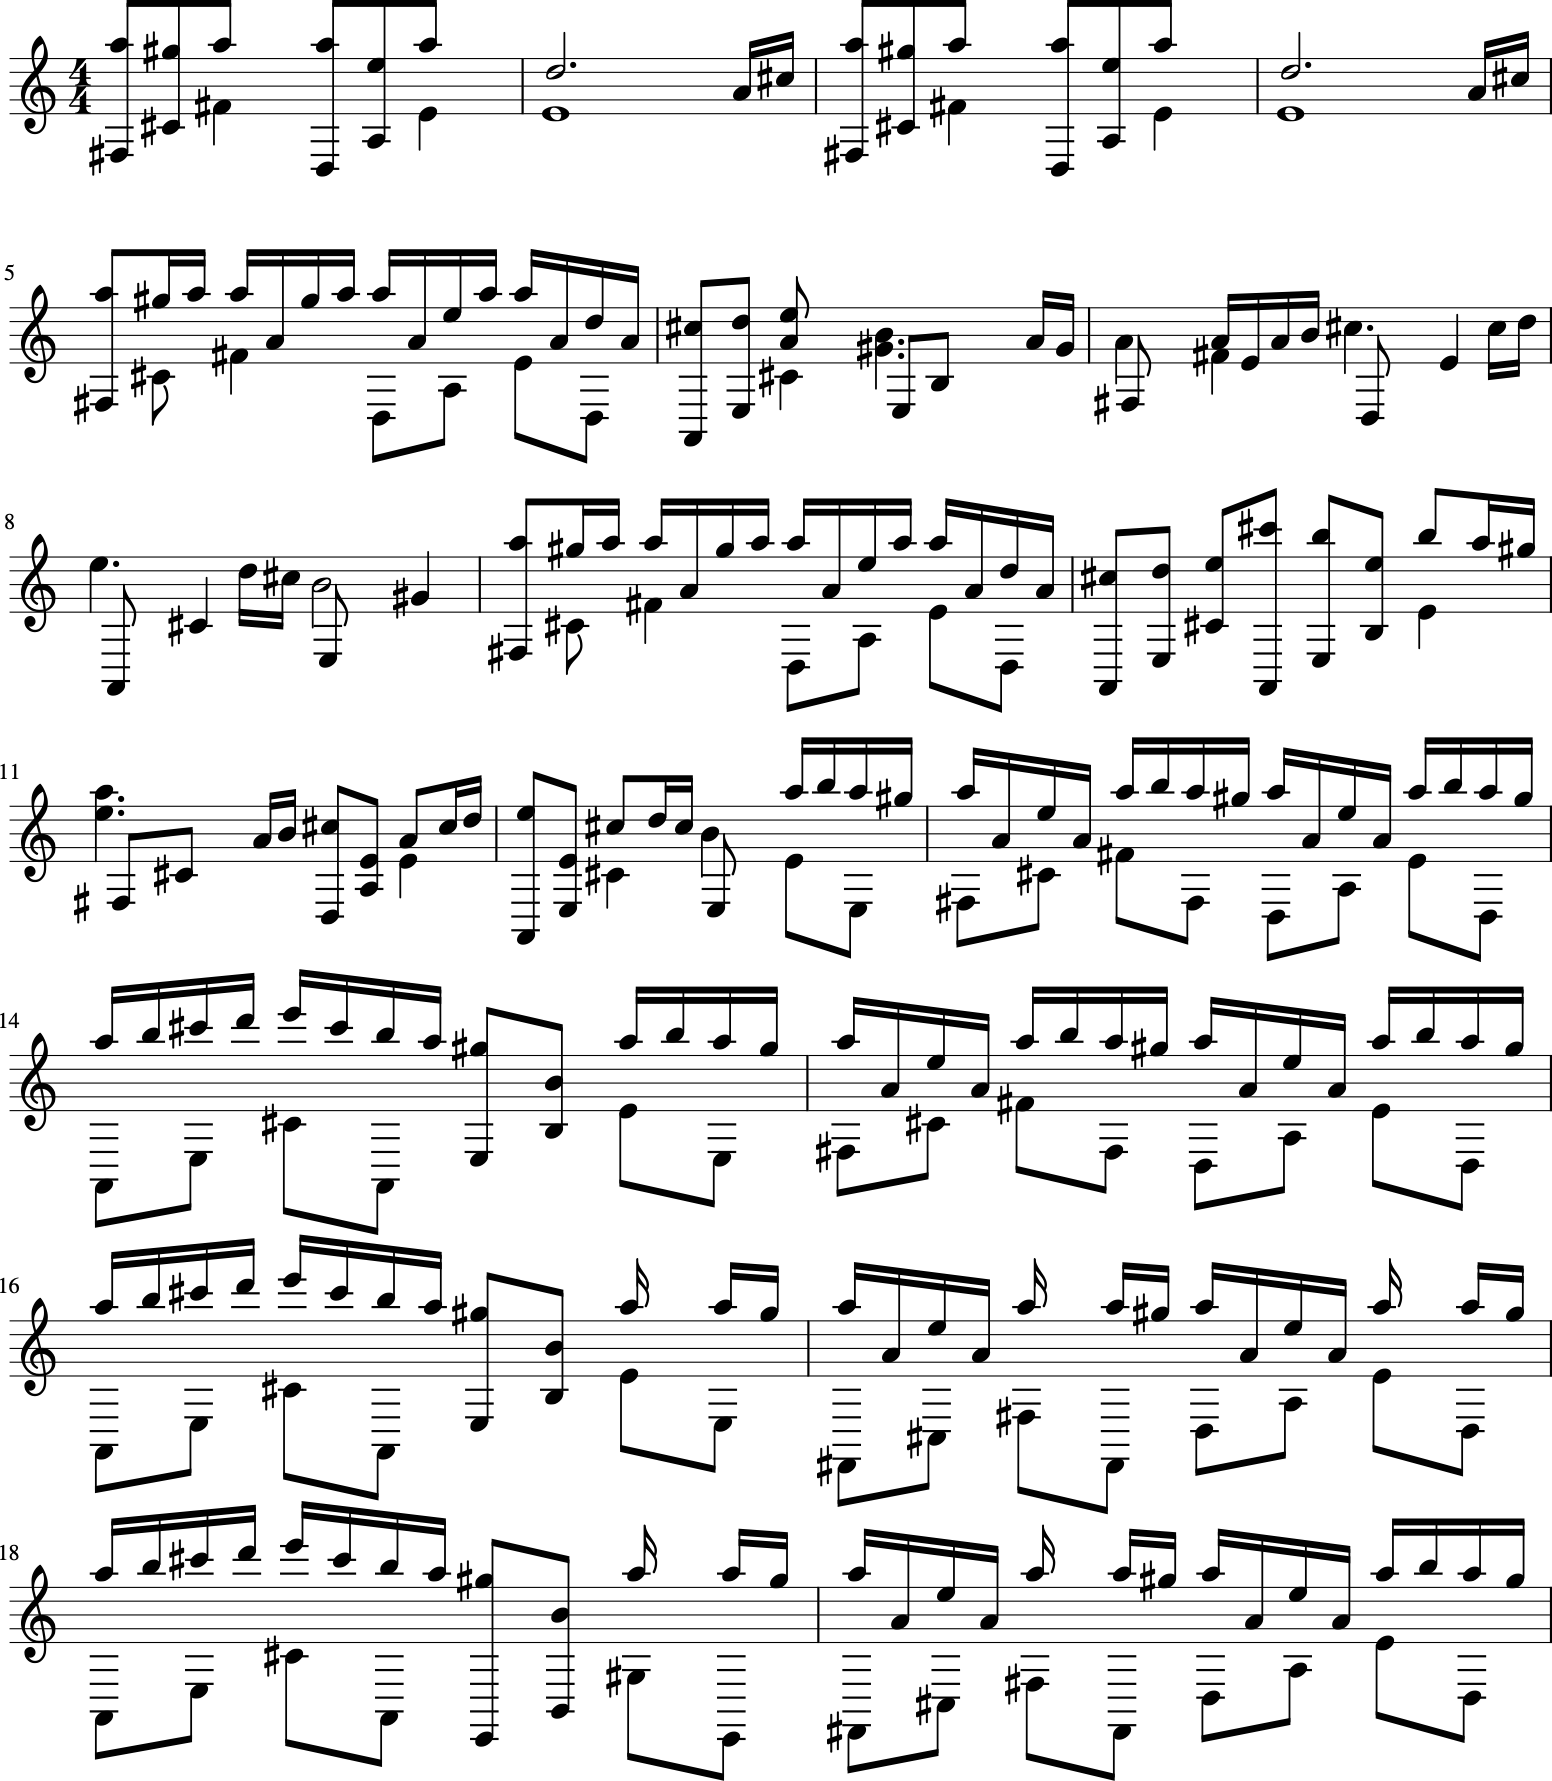

In [34]:
original_stream = npenc2stream(song_np)
original_stream.show()

In [35]:
original_stream.show('midi')